In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import math
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic
from schemdraw import dsp

## setup spice library path
directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

In [2]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    __R = 100@u_kΩ;
    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__name__ = name
        self.__R = R
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )
        
    def wiper(self, w) :
        if w == 0 :
            self.R1.resistance = self.__R * 0.0000001
            self.R2.resistance = self.__R * 0.9999999
        elif w == 1 :
            self.R1.resistance = self.__R * 0.9999999
            self.R2.resistance = self.__R * 0.0000001
        else :
            self.R1.resistance = self.__R * w
            self.R2.resistance = self.__R * (1.0-w)

class DMMT3904W(SubCircuitFactory):
    __name__ = 'DMMT3904W'
    __nodes__ = ('1', '2', '3', '4', '5', '6' )
    def __init__(self, name='DMMT3904W'):
        self.__name__ = name
        super().__init__()
        self.BJT(101, '6', '1', '5', model="BC846B")
        self.BJT(102, '3', '2', '4', model="BC846B")

class DMMT3906W(SubCircuitFactory):
    __name__ = 'DMMT3906W'
    __nodes__ = ('1', '2', '3', '4', '5', '6' )
    def __init__(self, name='DMMT3906W'):
        self.__name__ = name
        super().__init__()
        self.BJT(103, '6', '1', '5', model="BC556B")
        self.BJT(104, '3', '2', '4', model="BC556B")
        

# construction

The AD/AR contains two envelope circuits and one pulse timer. Both will have a trigger at the end of the envelope or delayed pulse. The end of envelope is not connected to another input, those must be patched. The output of the delayed pulse is connected to the input of the first envelope.

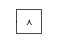

In [3]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.4, lw=0.7, fontsize=9)

d += dsp.Square().label('$\curlywedge$')

d.draw()


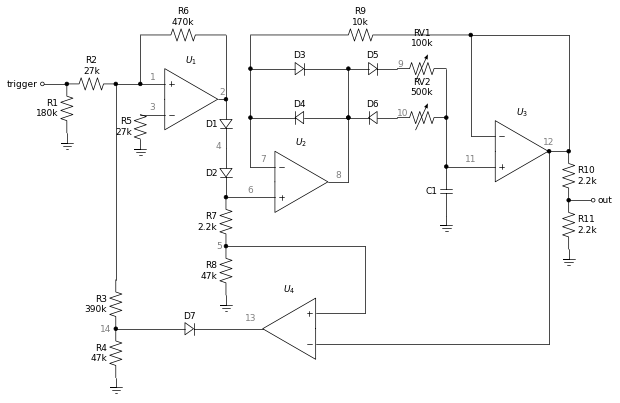

In [4]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.4, lw=0.7, fontsize=9)

d += (op1 := elm.Opamp().at([5,0]).flip().label('$U_1$'))
d += elm.Line().left().at(op1.in1).length(d.unit/2).label('3', color='Grey')
d += elm.Resistor().down().length(d.unit/2).label('R5\n27k')
d += elm.Ground()

d += elm.Line().length(d.unit/2).left().at(op1.in2).label('1', color='Grey')
d += elm.Dot()
d.push()
d += elm.Line().length(d.unit/2).left()
d += ( Dot0 := elm.Dot())
d += elm.Resistor().label('R2\n27k')
d += elm.Dot()
d.push()
d += elm.Resistor().label('R1\n180k').down()
d += elm.Ground()
d.pop()
d += elm.Line().length(d.unit/2).left()
d += elm.Dot(open=True).label('trigger', loc="lft")
d.pop()
d += elm.Line().up().length(d.unit)
d += ( R3 := elm.Resistor().right().length(d.unit*1.75).label('R6\n470k'))
d += elm.Line().down().toy(op1.out)
d += elm.Dot()
d.push()
d += elm.Line().left().tox(op1.out).label('2', color='Grey')

d.pop()
d += elm.Diode().down().label('D1')
d += elm.Diode().down().label('D2').label('4', loc='start', color='Grey', ofst=(-.1, -0.2) )
d += elm.Dot()
d.push()

d += elm.Resistor().down().label('R7\n2.2k')
d += ( Dot1 := elm.Dot()).label('5', loc='left', color='Grey')
d += elm.Resistor().down().label('R8\n47k')
d += elm.Ground()

d.pop()
d += elm.Line().right().label('6', color='Grey')
d += (op2 := elm.Opamp().anchor('in2').label('$U_2$'))

d += elm.Line().at(op2.in1).left().length(d.unit/2).label('7', color='Grey')
d += elm.Line().up()
d += elm.Dot()
d.push()
d += elm.Diode().right().reverse().length(d.unit*2).label('D4')
d += elm.Dot()

d += elm.Dot()
d += elm.Diode().reverse().label('D6').label('10', loc='end', color='Grey', ofst=(0, .2) )
d += elm.ResistorVarIEEE().label('RV2\n500k')
d += elm.Dot()

d.pop()
d += elm.Line().up()
d += ( Dot2 := elm.Dot())
d += elm.Diode().right().length(d.unit*2).label('D3')
d += elm.Dot()
d.push()
d += elm.Diode().label('D5').label('9', loc='end', color='Grey', ofst=(0, .2) )
d += elm.ResistorVarIEEE().label('RV1\n100k')

d += elm.Line().down().length(d.unit*2)
d += elm.Dot()
d.push()
d += elm.Capacitor().label('C1')
d += elm.Ground()

d.pop()
d += elm.Line().right().length(d.unit).label('11', color='Grey')
d += (op3 := elm.Opamp().anchor('in2').label('$U_3$'))

d.pop()
d += elm.Line().down().toy(op2.out)
d += elm.Line().left().tox(op2.out).label('8', color='Grey')

d += elm.Line().at(op3.in1).length(d.unit/2).left()

d += elm.Line().up().toy(R3.end)
d += elm.Dot()
d.push()
d += elm.Resistor().left().label('R9\n10k').tox(Dot2.end)
d += elm.Line().down().toy(Dot2.end)

d.pop()
d += elm.Line().right().length(d.unit*2)
d += elm.Line().down().toy(op3.out)
d += elm.Dot()
d.push()

d += ( D3 := elm.Line().left().length(d.unit*0.4))
d += elm.Dot().label('12', color='Grey')
d += elm.Line().left().tox(op3.out)

d.pop()
d += elm.Resistor().down().label('R10\n2.2k', loc='bottom')
d += elm.Dot()
d.push()
d += elm.Resistor().down().label('R11\n2.2k', loc='bottom')
d += elm.Ground()

d.pop()
d += elm.Line().right().length(d.unit/2)
d += elm.Dot(open=True).label('out', loc='right')

d += elm.Line().at(Dot0.end).down().length(d.unit*4)
d += elm.Resistor().label('R3\n390k')
d += elm.Dot().label('14', loc='left', color='Grey')
d.push()
d += elm.Resistor().label('R4\n47k')
d += elm.Ground()

d.pop()
d += elm.Diode().right().length(d.unit*3).label('D7').label('13', color='Grey', ofst=(2.5, 0))
#d += elm.Line().right().length(d.unit*3).label('14', color='Grey')
d += (op4 := elm.Opamp().anchor('out').label('$U_4$')).left()

d += elm.Line().right().at(op4.in1).tox(D3.end)
d += elm.Line().up().toy(D3.end)

d += elm.Line().right().at(op4.in2)
d += elm.Line().up().toy(Dot1.end)
d += elm.Line().left().tox(Dot1.end)

d.draw()




.title KiCad schematic
.include /github/workspace/lib/spice/transistor/DMMT3906W.lib
.include /github/workspace/lib/spice/transistor/DMMT3904W.lib
.include /github/workspace/lib/spice/transistor/bc5x7.lib
.include /github/workspace/lib/spice/opamp/TL072-dual.lib
.subckt DMMT3904W 1 2 3 4 5 6
Q101 6 1 5 BC846B
Q102 3 2 4 BC846B
.ends DMMT3904W

.subckt DMMT3906W 1 2 3 4 5 6
Q103 6 1 5 BC556B
Q104 3 2 4 BC556B
.ends DMMT3906W

.subckt RV1 n1 n2 n3
R1 n1 n2 23.5kOhm
R2 n2 n3 23.5kOhm
.ends RV1
R3 Net-_Q1-Pad1_ +5V 220
R10 Net-_C1-Pad2_ +5V 220
R14 Net-_Q3-Pad4_ -15V 10k
C2 Net-_C2-Pad1_ +5V 1n
R12 Net-_Q3-Pad4_ Net-_C1-Pad2_ 10k
R6 Net-_Q1-Pad4_ Net-_Q7-Pad3_ 1k
R16 Net-_Q4-Pad1_ +5V 220
R20 Net-_Q4-Pad2_ +5V 220
R22 Net-_Q8-Pad5_ -15V 10k
C5 Net-_C5-Pad1_ +5V 1n
R21 Net-_Q8-Pad5_ Net-_Q4-Pad2_ 10k
R18 Net-_Q4-Pad4_ Net-_Q8-Pad3_ 1k
R17 Net-_Q4-Pad2_ Net-_Q3-Pad4_ 10k
R23 Net-_Q9-Pad1_ +5V 220
R26 Net-_Q11-Pad2_ +5V 220
R28 Net-_Q12-Pad4_ -15V 10k
C6 Net-_C6-Pad1_ +5V 1n
R27 Net-_Q12-Pad4

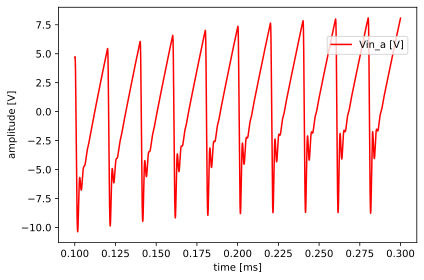

In [5]:
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

circuit = parser.build_circuit(ground=5)
circuit.include(spice_library['DI_DMMT3906W']) #PNP
circuit.include(spice_library['DI_DMMT3904W']) #NPN
circuit.include(spice_library['BC846B']) #PNP
circuit.include(spice_library['BC556B']) #NPN
circuit.include(spice_library['TL072c'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', '+5V', circuit.gnd, 'DC 5')
circuit.V('4', '/IN', circuit.gnd, 'AC 5 DC 5 Pulse(0 5 0 0 20m 0.1m 20m)')
circuit.V('5', '/CV', circuit.gnd, 'DC -3')

for c in (DMMT3904W(), DMMT3906W(), VoltageDivider(R=47@u_kΩ, w=0.5, name='RV1')) :
    circuit.subcircuit(c)

circuit.R(100, '/OUT', circuit.gnd, 100@u_kOhm)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=300@u_ms)
    

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(analysis['/OUT'].abscissa, analysis['/OUT'], color='Red')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()



In this circuit U1 is a latch. It goes high when there is an input signal. 

/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, gain, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:46: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, phase, basex=10, **kwargs)


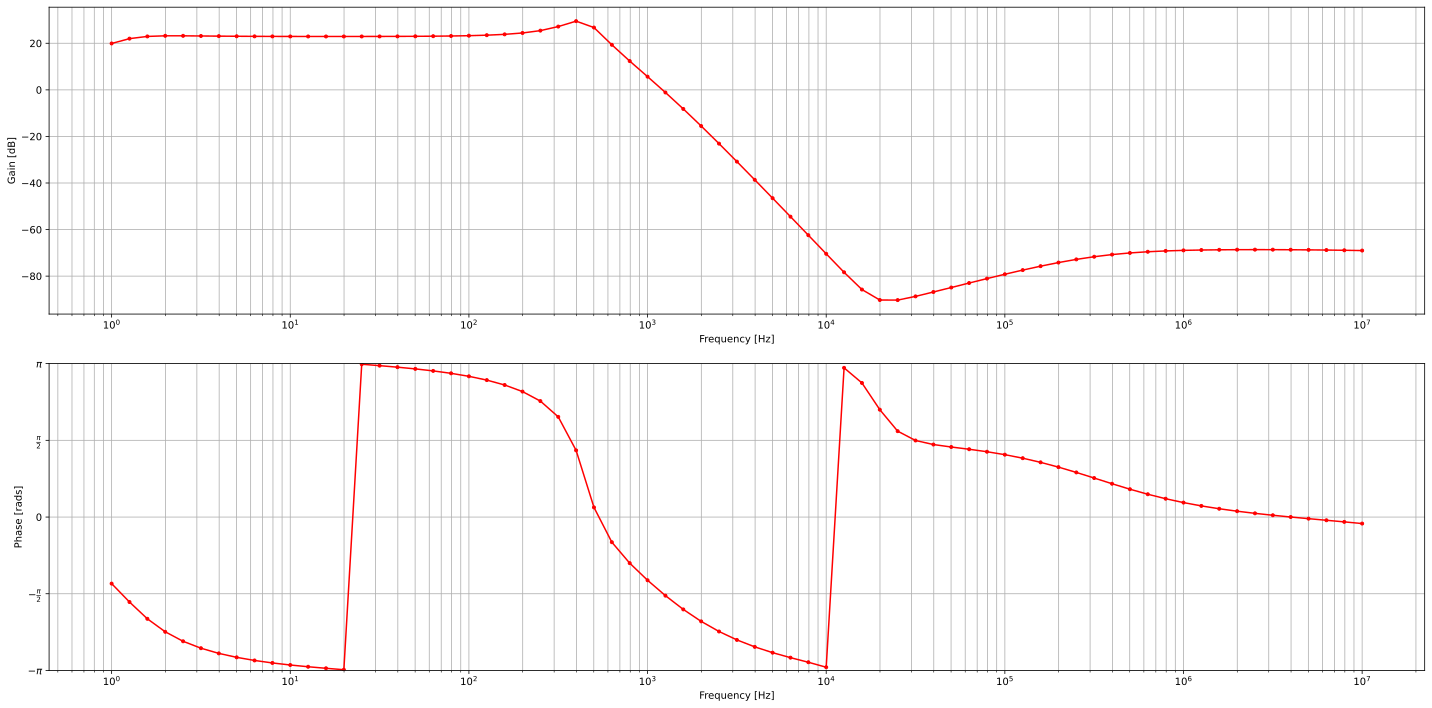

In [6]:
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=10@u_MHz, number_of_points=10,  variation='dec')

################################################################
# draw bode diagram
from PySpice.Plot.BodeDiagram import bode_diagram
figure = plt.figure(1, (20, 10))
plt.title("Bode Diagram of a Low-Pass RC Filter")
axes = (plt.subplot(211), plt.subplot(212))
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac['/out'])),
             phase=np.angle(analysis_ac['/out'], deg=False),
             marker='.',
             color='red',
             linestyle='-',
         )

plt.tight_layout()
plt.show()


For the end of envelope trigger we use another comperator. This comperator will trigger at about 0.6V. The trigger starts on he falling edge and ends on the rising edge at 0.6 V again (Orange). An AND gate will limit the trigger to the falling gate. One input is the output of the comperator the other the inverted output of the latch.

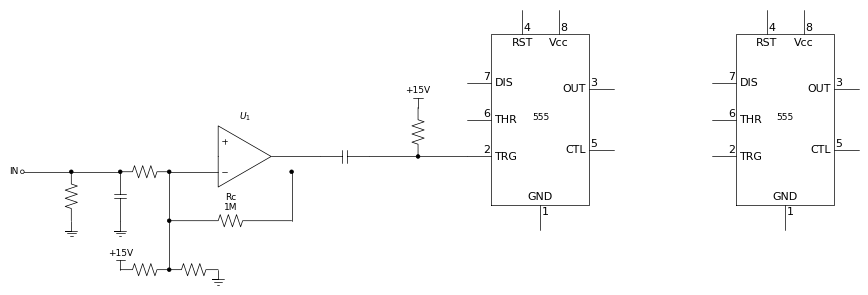

In [7]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.4, lw=0.7, fontsize=9)

d += ( U2 := elm.Ic555().at([10,0]))
d += ( U3 := elm.Ic555().at([20,0]))

d += elm.Line().left().at(U2.TRG)
d += elm.Dot()
d.push()
d += elm.Line()
d += elm.Capacitor()
d += elm.Line()
d += (U1 := elm.Opamp().reverse().anchor('out').label('$U_1$'))

d.pop()
d += elm.Resistor().up()
d += elm.Vdd().label('+15V')

d += elm.Line().left().at(U1.in1)
d += elm.Dot()
d.push()
d += elm.Resistor().left()
d += elm.Dot()
d.push()
d += elm.Line()
d += elm.Dot()
d.push()
d += elm.Line()
d += elm.Dot(open=True).label('IN', loc='left')

d.pop()
d += elm.Resistor().down()
d += elm.Ground()

d.pop()
d += elm.Capacitor().down()
d += elm.Ground()


d.pop()
d += elm.Line().down()
d += elm.Dot()
d.push()
d += elm.Resistor().right().length(d.unit*2.5).label('Rc\n1M')
d += elm.Line().up()
d += elm.Dot()

d.pop()
d += elm.Line().down()
d += elm.Dot()
d.push()

d += elm.Resistor().left()
d += elm.Vdd().label('+15V')
d.pop() 
d += elm.Resistor().right()
d += elm.Ground()




d.draw()


{% include bom.html content="summe-main-bom" %}
{% include callouts.html %}
{% include reports.html%}

In [8]:
from IPython.core.display import display, HTML
display(HTML('''
<div class="hero is-medium" style="background: url('{{ '/assets/cmos_buffer_files/tmb_ube_screamer.jpg' | relative_url }}') no-repeat center center; background-size: cover; background-attachment: fixed;">
   <div class="hero-body">
        <div class="content has-text-centered">
        </div>
    </div>
</div>
'''))

# references

[René Schmitz](https://www.schmitzbits.de/rs2040.html) SMD SSM 2040 filter
https://synthtech.com/docs/MOTM-440_manual.pdf